In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle

import matplotlib.pyplot as plt
import cv2

In [18]:
# load all models
# haarcascade , ml model , pca
haar = cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml') #cascade classifier
model_svm = pickle.load(open('./model/model_svm.pickle', mode='rb')) # machine learning model (SVM)
pca_models = pickle.load(open('./model/pca_dict.pickle', mode='rb')) # pca dictionary


In [19]:
#pca basically contains two things: one is the pca_model and other one is the mean face
#we need to separately extract these two models
model_pca = pca_models['pca'] # PCA MODEL
mean_face_arr = pca_models['mean face'] # MEAN EIGEN FACE

### Create Pipeline

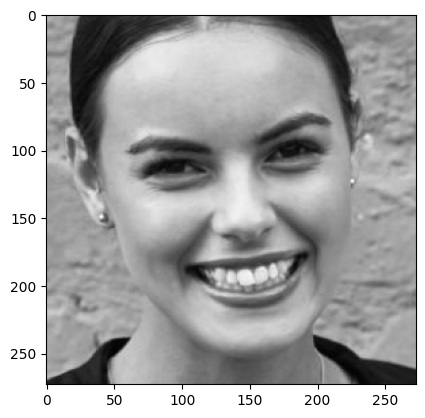

female: 62


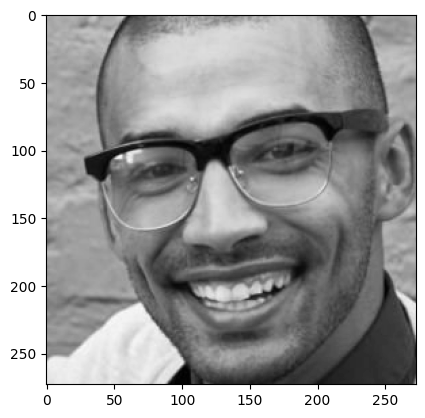

male: 95


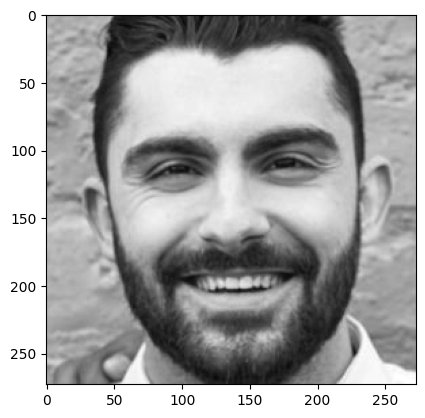

male: 99


In [40]:
# Step-0: read image
img = cv2.imread('./test_images/getty_test.jpg') # BGR format
# Step-1: convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Step-2: crop the face (using haar cascade classifier)
faces = haar.detectMultiScale(gray, 1.5,3)
predictions = []
for x,y,w,h in faces:
    #cv2.rectangle(img, (x,y), (x+w,y+h),(0,255,0),2)
    roi = gray[y:y+h,x:x+w]
    plt.imshow(roi, cmap='gray')
    plt.show()
    # Step-3: normalization(0-1)
    roi = roi / 255.0
    # Step-4: resize images (100,100)
    if roi.shape[1] > 100:
        roi_resize = cv2.resize(roi, (100,100), cv2.INTER_AREA)
    else:
        roi_resize = cv2.resize(roi, (100,100), cv2.INTER_CUBIC)
    # Step-5: flattening ( 1x10000)
    roi_reshape = roi_resize.reshape(1,10000)
    # Step-6: subtract with mean
    roi_mean = roi_reshape - mean_face_arr # subtracting face with mean face
    # Step-7: get eigen image (apply roi_mean to pca)
    eigen_image = model_pca.transform(roi_mean)
    # Step-8: Eigen Image for Visualization 
    eig_img = model_pca.inverse_transform(eigen_image)
    # Step-9: pass to ml model(svm) and get predictions
    results = model_svm.predict(eigen_image)
    prob_score = model_svm.predict_proba(eigen_image)
    prob_score_max = prob_score.max()
   # print(results, prob_score)
    # Step-10: generate report
    text = "%s: %d"%(results[0], prob_score_max*100)
    print(text)
    # defining the colors based on results
    if results[0] == 'male':
        color = (255,255,0)
    else:
        color = (255,0,255)
    cv2.rectangle(img, (x,y), (x+w,y+h),color,2)
    cv2.rectangle(img,(x,y-40), (x+w,y),color, -1)
    cv2.putText(img, text, (x,y),cv2.FONT_HERSHEY_PLAIN,3,(255,255,255),5)
    output = {
        'roi':roi,
        'eig_img':eig_img,
        'prediction_name':results[0],
        'score':prob_score_max
    }
    
    predictions.append(output)

In [42]:
predictions

[{'roi': array([[0.6       , 0.60784314, 0.61960784, ..., 0.57254902, 0.57647059,
          0.58039216],
         [0.61568627, 0.61960784, 0.62352941, ..., 0.57254902, 0.57647059,
          0.57647059],
         [0.65490196, 0.65490196, 0.65098039, ..., 0.56862745, 0.56470588,
          0.56078431],
         ...,
         [0.28627451, 0.20392157, 0.15294118, ..., 0.10980392, 0.10588235,
          0.10588235],
         [0.17647059, 0.14117647, 0.1254902 , ..., 0.10980392, 0.10588235,
          0.10196078],
         [0.10980392, 0.10588235, 0.10980392, ..., 0.10588235, 0.10196078,
          0.09803922]]),
  'eig_img': array([[ 0.29494806,  0.28649627,  0.27799191, ..., -0.04993929,
          -0.03323594, -0.03574072]]),
  'prediction_name': 'female',
  'score': 0.6202947924812602},
 {'roi': array([[0.71764706, 0.70980392, 0.69019608, ..., 0.60392157, 0.60784314,
          0.61568627],
         [0.69803922, 0.68627451, 0.67058824, ..., 0.62352941, 0.62745098,
          0.61960784],
      

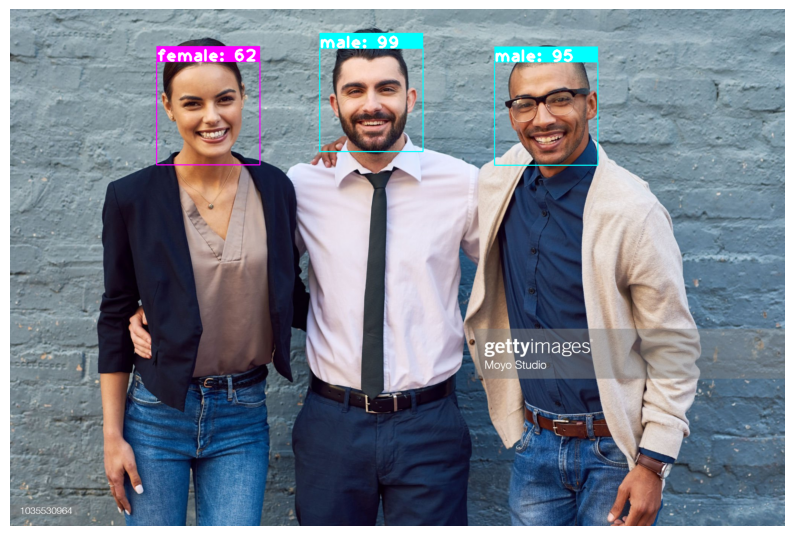

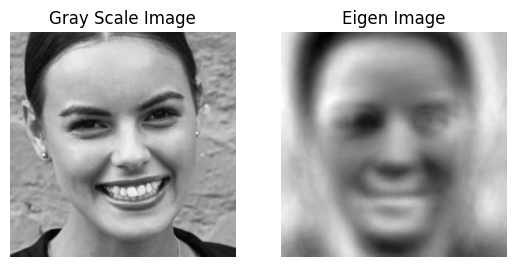

Predicted Gender = female
Predicted Score = 62.03%
----------------------------------------------------------------------------------------------------


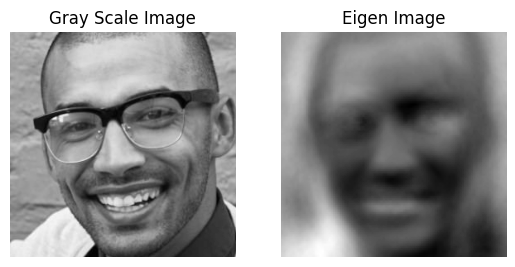

Predicted Gender = male
Predicted Score = 95.34%
----------------------------------------------------------------------------------------------------


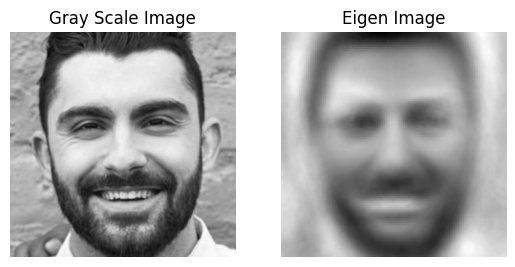

Predicted Gender = male
Predicted Score = 99.14%
----------------------------------------------------------------------------------------------------


In [52]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(img_rgb) # matplotlib shows the image in rgb 
plt.axis('off')
plt.show()

# generate report
for i in range(len(predictions)):
    obj_gray = predictions[i]['roi'] # grayscale cropped image
    obj_eig = predictions[i]['eig_img'].reshape(100,100) # eigen image
    plt.subplot(1,2,1)
    plt.imshow(obj_gray, cmap='gray')
    plt.title('Gray Scale Image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(obj_eig, cmap='gray')
    plt.title('Eigen Image')
    plt.axis('off')
    
    plt.show()
    print('Predicted Gender =', predictions[i]['prediction_name'])
    print('Predicted Score = {:,.2f}%'.format(predictions[i]['score']*100))
    print('-'*100)
    